A/B test for checkout page redesign in a clothing online store mobile application

Context: The online clothing store is considering improving the checkout process by adding Quick Checkout functionality. The main idea -  to remove barriers to purchase and encourages users to complete their transactions quickly and efficiently.
Quick Checkout feature.
An A/B test is being conducted. Users are randomly assigned to two groups: Control group A, which experiences the existing checkout process, and Treatment group B, which experiences the checkout process with the Quick Checkout feature 

In [155]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta
from scipy.stats import binom
from scipy.stats import norm
#from statsmodels.stats.proportion import proportions_ztest


Simulating Data

In [125]:
np.random.seed(101)
num_users = 2000

columns = ['User ID', 'Session Duration', 'Checkout Page Visit', 'Variant', 'Payment Confirmation', 'Order Number', 'Order Date', 'Order Sum']
df = pd.DataFrame(columns=columns)

# Simulate data for each user and append to DataFrame
for user_id in range(1, num_users + 1):
    order_number = np.nan
    order_date = np.nan
    order_sum = np.nan
    
    variant = random.choice(['A', 'B'])
    
     # Simulate session duration
    session_dur = round(random.uniform(1, 20), 2)
    
    # Simulate checkout page visit
    checkout_page_visit = np.random.binomial(1, 0.5)
    
    # Simulate payment confirmation (1 or 0, only if checkout page was visited)
    payment_confirmation = np.nan if checkout_page_visit == 0 else np.random.binomial(1, 0.7)
    
    # Check if payment confirmation is 1, generate order details
    if payment_confirmation == 1:
        order_number = random.randint(1000, 9999)
        order_date = (datetime.today() - timedelta(days=random.randint(1, 30))).date()
        order_sum = round(random.uniform(10, 500), 2)
    
    # Create temporary DataFrame for each user
    df_temp = pd.DataFrame({
        'User ID': [user_id],
        'Session Duration': [session_dur],
        'Checkout Page Visit': [checkout_page_visit],
        'Variant': [variant],
        'Payment Confirmation': [payment_confirmation],
        'Order Number': [order_number],
        'Order Date': [order_date],
        'Order Sum': [order_sum]
    })
    
    # Append the temporary DataFrame to the main DataFrame
    df = pd.concat([df, df_temp], ignore_index=True)

df

,User ID,Session Duration,Checkout Page Visit,Variant,Payment Confirmation,Order Number,Order Date,Order Sum
0,1,18.06,1,B,1,4713,2024-02-15,320.23
1,2,9.19,0,B,NaN,NaN,NaN,NaN
2,3,14.29,0,B,NaN,NaN,NaN,NaN
3,4,13.45,1,A,0,NaN,NaN,NaN
4,5,8.65,0,A,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1995,1996,19.23,0,B,NaN,NaN,NaN,NaN
1996,1997,13.85,1,A,1,7751,2024-02-10,407.73
1997,1998,11.10,1,B,1,2938,2024-03-05,35.75
1998,1999,18.82,1,B,1,2604,2024-03-05,407.20


Total number of users:  2000
Number of users in Control group A:  985
Number of users in Treatment group B:  1015


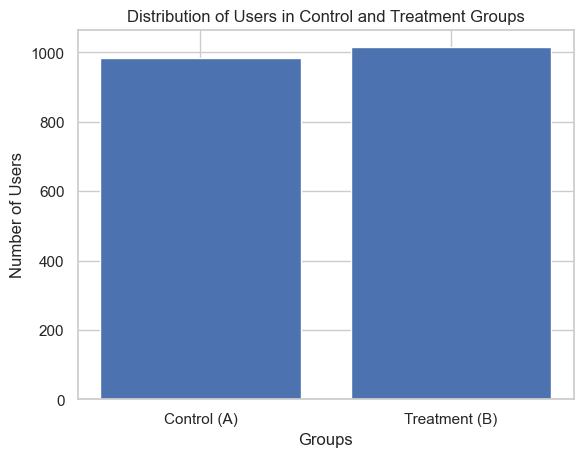

In [126]:
# Data Check
# Check number of unique users
unique_users = df['User ID'].nunique()

print ("Total number of users: ", unique_users)

# Counting the number of users in each group.
n_users_A = df[df['Variant'] == 'A']['User ID'].value_counts().sum()
n_users_B = df[df['Variant'] == 'B']['User ID'].value_counts().sum()

print ("Number of users in Control group A: ", n_users_A) 
print ("Number of users in Treatment group B: ", n_users_B)

plt.bar(['Control (A)', 'Treatment (B)'], [n_users_A, n_users_B])
plt.xlabel('Groups')
plt.ylabel('Number of Users')
plt.title('Distribution of Users in Control and Treatment Groups')
plt.show()

In [127]:
# Counting the number of checkout page visits
n_checkout_vis = df['Checkout Page Visit'].sum()
print("Number of checkout page visits:", n_checkout_vis)

# Counting the number of payment confirmations
n_payment_conf = df['Payment Confirmation'].sum()
print("Number of payment confirmations:", n_payment_conf)

# Counting the number of orders placed
n_orders = df['Order Number'].count()
print("Number of orders placed:", n_orders)

Number of checkout page visits: 989
Number of payment confirmations: 704
Number of orders placed: 704


In [128]:
df.groupby('Variant')[['Session Duration', 'Checkout Page Visit', 'Payment Confirmation', 'Order Sum']].agg(['sum','mean','std'])

Session Duration                      Checkout Page Visit            \
                     sum       mean       std                 sum      mean   
Variant                                                                       
A               10083.48  10.237036  5.471743                 489  0.496447   
B               10488.99  10.333980  5.458729                 500  0.492611   

                  Payment Confirmation                     Order Sum  \
              std                  sum      mean       std       sum   
Variant                                                                
A        0.500241                  344  0.703476  0.457192  86602.04   
B        0.500192                  360  0.720000  0.449449  92756.68   

                                 
               mean         std  
Variant                          
A        251.750116  142.295177  
B        257.657444  148.895655

In summary, the dataset consists of 2000 unique users, with approximately equal distribution between the control (Group A) and treatment (Group B) groups. The data appears to be complete and reliable for further analysis, as there are no significant discrepancies or issues observed.

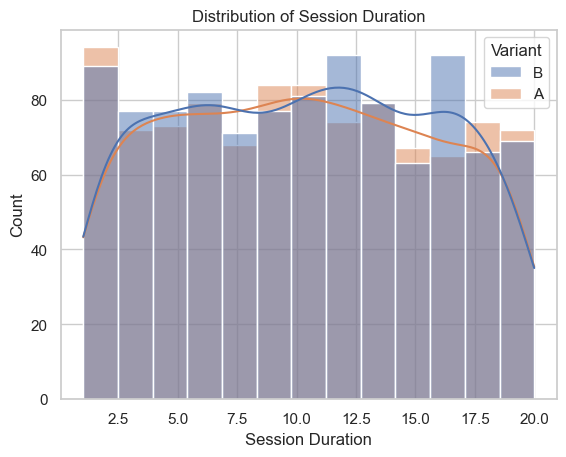

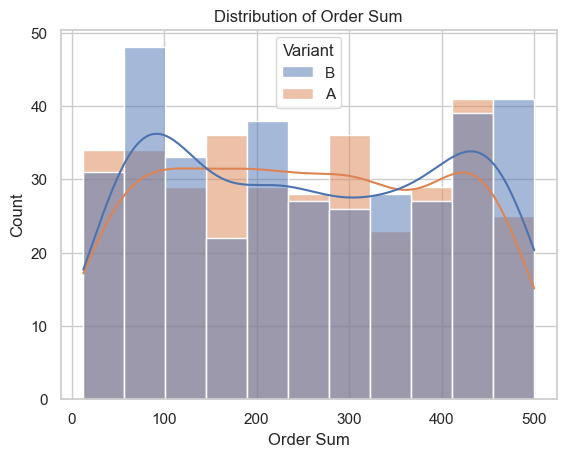

In [129]:
#Visualizing the metrics distribution for each group
sns.histplot(x='Session Duration', hue='Variant', data=df, kde=True)
plt.title('Distribution of Session Duration')
plt.show()

sns.histplot(x='Order Sum', hue='Variant', data=df, kde=True)
plt.title('Distribution of Order Sum')
plt.show()


Null Hypothesis (H0): Changing the appearance of the payment method selection block does not significantly affect the checkout conversion rate.

Alternative Hypothesis (H1): Changing the appearance of the payment method selection block affects the checkout conversion rate.

Primary metric - checkout conversion rate - the ratio of the number of orders to the number of visitors who visited the checkout page. 
Secondary metrics - Average Revenue per User and Conversion Rate by Order Value

Significance Level alpha = 0.05

Primary metric - checkout conversion rate

In [130]:
# Calculate conversion rate for each group
conv_rate_A = df[df['Variant'] == 'A']['Checkout Page Visit'].mean() 
conv_rate_B = df[df['Variant'] == 'B']['Checkout Page Visit'].mean() 

print('Conversion rate for Control group A:', round(conv_rate_A, 2))
print('Conversion rate for Control group B:', round(conv_rate_B, 2))

Conversion rate for Control group A: 0.5
Conversion rate for Control group B: 0.49


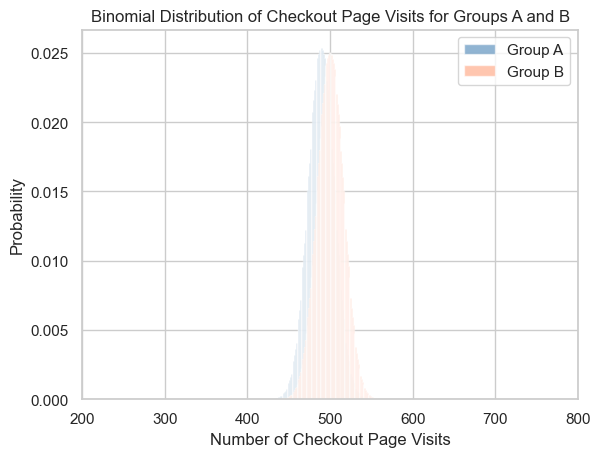

In [141]:
#plot the binomial distribution of the two variants
# Set parameters for the binomial distribution
n_A = len(df[df['Variant']=='A'])# number of trials = sample size
n_B = len(df[df['Variant']=='B'])
p_A = conv_rate_A # probability of success 
p_B = conv_rate_B 

# Generate x-values
x_values_A = np.arange(0, n_A + 1)  # possible number of successes for group 
x_values_B = np.arange(0, n_B + 1)  

# Calculate PMF for each group
pmf_A = binom.pmf(x_values_A, n_A, p_A)
pmf_B = binom.pmf(x_values_B, n_B, p_B)

# Plot the PMF for Group A
plt.bar(x_values_A, pmf_A, label='Group A', alpha=0.6, color='steelblue')

# Plot the PMF for Group B
plt.bar(x_values_B, pmf_B, label='Group B', alpha=0.6, color='lightsalmon')

plt.xlabel('Number of Checkout Page Visits')
plt.ylabel('Probability')
plt.title('Binomial Distribution of Checkout Page Visits for Groups A and B')
plt.xlim(200,800)
plt.legend()
plt.show()

In [146]:
df['Checkout Page Visit'] = df['Checkout Page Visit'].astype(np.float64)

# Perform t-test
t_statistic, p_value = stats.ttest_ind(df[df['Variant'] == 'A']['Checkout Page Visit'],
                                       df[df['Variant'] == 'B']['Checkout Page Visit'])

print("t-statistic:", round(t_statistic, 2))
print("p-value:", round(p_value, 2))


t-statistic: 0.17
p-value: 0.86


t-statistic of 0.17 indicates that there is a very small difference between the means of the two groups.
p-value is much larger than 0.05, so we fail to reject the null hypothesis. In our case there is an 86% chance that the observed differences between the groups occurred by chance

Secondary metrics Average Revenue per Paying User and Average Order Values

In [177]:
# Calculate Average Revenue per Paying User (ARPPU) for each variant
arpu_A = df[df['Variant'] == 'A']['Order Sum'].sum() / df[df['Variant'] == 'A']['User ID'].nunique()
arpu_B = df[df['Variant'] == 'B']['Order Sum'].sum() / df[df['Variant'] == 'B']['User ID'].nunique()

print('Average Revenue per User for group A:', round(arpu_A, 2))
print('Average Revenue per User for group B:', round(arpu_B, 2))

Average Revenue per User for group A: 87.92
Average Revenue per User for group B: 91.39


In [169]:
revenue_per_user_A = df[df['Variant'] == 'A']['Order Sum'].dropna().values
revenue_per_user_B = df[df['Variant'] == 'B']['Order Sum'].dropna().values

std_dev_A = np.std(revenue_per_user_A)
std_dev_B = np.std(revenue_per_user_B)
print (round (std_dev_A,2), round(std_dev_B,2))

num_users_paying_A = df[df['Variant'] == 'A']['Order Sum'].dropna().value_counts().sum()
num_users_paying_B = df[df['Variant'] == 'B']['Order Sum'].dropna().value_counts().sum()
print('Number of Paying Users in Group A:', num_users_paying_A)
print('Number of Paying Users in Group B:', num_users_paying_B)

142.09 148.69
Number of Paying Users in Group A: 344
Number of Paying Users in Group B: 360


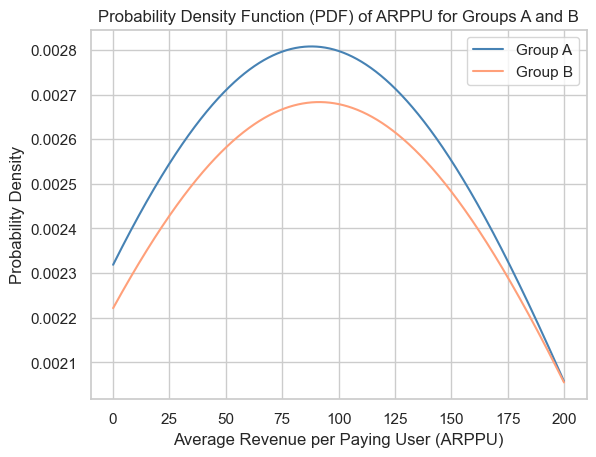

In [166]:
# For continuous variables like ARPPU will use the normal distribution

# Generate x-values for the range of ARPU values
x_values = np.linspace(0, 200, 1000)  # Adjust the range based on data

# Calculate PDF for each group
pdf_A = norm.pdf(x_values, arpu_A, std_dev_A)
pdf_B = norm.pdf(x_values, arpu_B, std_dev_B)

# Plot the PDF for each group
plt.plot(x_values, pdf_A, label='Group A', color='steelblue')
plt.plot(x_values, pdf_B, label='Group B', color='lightsalmon')

plt.xlabel('Average Revenue per Paying User (ARPPU)')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF) of ARPPU for Groups A and B')
plt.legend()
plt.show()


In [173]:
# Perform Z-test
standard_error_diff = ((std_dev_A**2) + (std_dev_B**2))**0.5

# Calculate the z-score
z_score = (arpu_A - arpu_B) / standard_error_diff

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(abs(z_score)))

# Print results
print("Z-score:", round(z_score,2))
print("P-value:", round(p_value,2))

Z-score: -0.02
P-value: 0.99


there is an 99% chance that the observed differences between the groups occurred by chance. We fail to reject the null hypothesis.

In [180]:
# Calculate conversion rate 'Payment Confirmation' for each group
payment_rate_A = df[df['Variant'] == 'A']['Payment Confirmation'].mean() 
payment_rate_B = df[df['Variant'] == 'B']['Payment Confirmation'].mean() 

print('Conversion rate for group A:', round(conversion_rate_A, 2))
print('Conversion rate for group B:', round(conversion_rate_B, 2))

Conversion rate for group A: 0.7
Conversion rate for group B: 0.72


In [181]:
# Calculate number of orders for each group
num_orders_A = df[df['Variant'] == 'A']['Payment Confirmation'].sum()
num_orders_B = df[df['Variant'] == 'B']['Payment Confirmation'].sum()

print("Number of orders for Control group A:", num_orders_A)
print("Number of orders for Treatment group B:", num_orders_B)

# Calculate average order value for each group
average_order_value_A = df[df['Variant'] == 'A']['Order Sum'].mean()
average_order_value_B = df[df['Variant'] == 'B']['Order Sum'].mean()

print('Average order value for Control group A: $', round(average_order_value_A, 2))
print('Average order value for Treatment group B: $', round(average_order_value_B, 2))

Number of orders for Control group A: 344
Number of orders for Treatment group B: 360
Average order value for Control group A: $ 251.75
Average order value for Treatment group B: $ 257.66


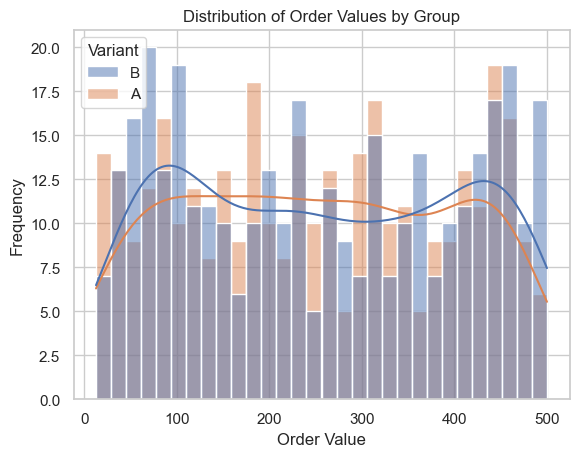

In [182]:
# Plot histograms for average order values
plt.figure()
sns.histplot(data=df, x='Order Sum', hue='Variant', bins=30, kde=True)
plt.title('Distribution of Order Values by Group')  
plt.ylabel('Frequency')  
plt.xlabel('Order Value') 
plt.show()

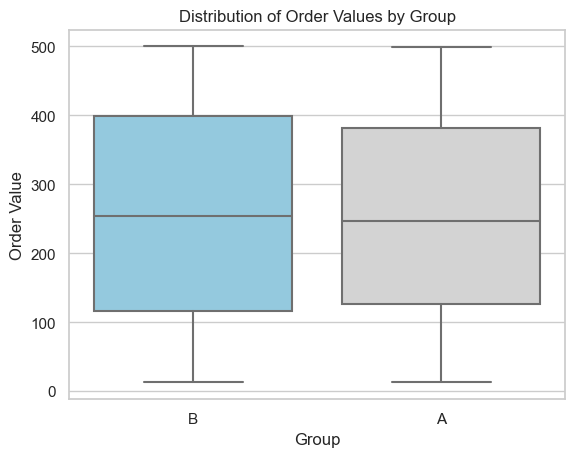

In [184]:
# Plot Box Plot of Order Values
plt.figure()
sns.boxplot(x='Variant', y='Order Sum', data=df, palette = {'skyblue','lightgrey'})
plt.title('Distribution of Order Values by Group')
plt.ylabel('Order Value')
plt.xlabel('Group')
plt.show()

In [187]:
# Exclude rows with missing values from the data before performing the t-test
group_A_values = df[df['Variant'] == 'A']['Order Sum'].dropna()
group_B_values = df[df['Variant'] == 'B']['Order Sum'].dropna()

# Perform t-test for average order values
t_stat, p_value_order = ttest_ind(group_A_values, group_B_values, equal_var=False)

print('T-statistic for Average Order Value:', round(t_stat,2))
print('P-value for Average Order Value:', round(p_value_order,2))

T-statistic for Average Order Value: -0.54
P-value for Average Order Value: 0.59


In [ ]:
With a p-value of 0.59, we fail to reject the null hypothesis. This suggests that there is no significant difference.

Conclusion:
Based on the analysis of primary metric Checkout Conversion Rate and additional secondary metrics Average Order Values, it appears that the changes made to the checkout process did not have a significant impact on user behavior. 
Both tests fail to provide evidence to reject the null hypothesis. Therefore, it's likely that the changes did not lead to statistically significant improvements.